# COMP5318 - Machine Learning and Data Mining - S1 2018

## Assignment 1 - Due 07 May 2018, 5:00pm

#### Group Members (name and student number):


*   Qinqing Peng 470476783
*   Sheng Yuan 430058318


####Group number:
* 27

####Tutors：
* Harrison Nguyen
* Aswani Kumar



---



## Authenticate and create PyDrive client.

You will be prompted with a link to click on, and give permission to Google Colab to access your Google Drive. If you don't want to give permission to your personal google drive, create a new gmail account, and complete this process using the new account.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


## Import data
Locate the "Data" folder in your drive. Right click and click "share" to get the ID of the folder. Replace < Data folder id > with the id you got. (id should look like "1j8oG_vCmum965Ghg8LdbSkfj-lfi-AZ0" )

In [2]:

file_list = drive.ListFile({'q': "'13QlIgSDntoZxVFBF7o4FRFzWsFwVNyNg' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: test_data.csv, id: 1evZ4lcnP_VnlelF84CDKslnDYpn2Kv1D
title: training_data.csv, id: 1UgFDLaazt3oAFOtlhES684IEf5w5nfE2
title: training_desc.csv, id: 13455ApgFE4pcbaqCBLRUaIp0VbUTkH7p
title: training_labels.csv, id: 1UsnxPt7ByOCw0i2HonwUJVaZI3bOaIcA


### Pulling data into Google Colab.

In [0]:
training_data_downloaded = drive.CreateFile({'id': '1UgFDLaazt3oAFOtlhES684IEf5w5nfE2'})
training_data_downloaded.GetContentFile('training_data.csv')

training_desc_downloaded = drive.CreateFile({'id': '13455ApgFE4pcbaqCBLRUaIp0VbUTkH7p'})
training_desc_downloaded.GetContentFile('training_desc.csv')

training_labels_downloaded = drive.CreateFile({'id': '1UsnxPt7ByOCw0i2HonwUJVaZI3bOaIcA'})
training_labels_downloaded.GetContentFile('training_labels.csv')

test_data_downloaded = drive.CreateFile({'id': '1evZ4lcnP_VnlelF84CDKslnDYpn2Kv1D'})
test_data_downloaded.GetContentFile('test_data.csv') 

In [0]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,hstack,vstack
from scipy.sparse.linalg import svds
import io
import matplotlib.pyplot as plt
import seaborn as sn
import datetime


### Load data files


In [0]:
#loading data
table = pd.read_csv('training_data.csv',delimiter=',',header=None,index_col=0).astype(np.float32).sort_index()
labels = pd.read_csv('training_labels.csv',delimiter=',',header=None,index_col=0).sort_index()
df_test = pd.read_csv('test_data.csv',delimiter=',',header=None,index_col=0).astype(np.float32)
labels=labels.reset_index(drop=True)
table=table.reset_index(drop=True)



---


## A. Introduction (max 500 words)


1- What is the aim of the study?


In this study, we aimed to perform machine learning processes to build a classifier to classify apps’ categories based on the descriptions of the apps. This study also included data mining techniques to extract information of the apps from their descriptions. In order to achieve our goal, we performed methods such as principal component analysis, gradient descent algorithm, logistic regression, Naive Bayes theorem and etc. The hardware we used is a MacBook Pro with processor of 2.5 GHz Intel Core i7. We used Colab for this study, so that each team member would be able to see and make adjustment to the project.

There were four datasets provided, training_data.csv, training_dec.csv, training_labels.csv and test_data.csv. We used training_data csv and training_labels.csv to perform and modify machine learning processes such as building and testing classifiers.  After examining our classifiers, we then used test_data.csv to make predictions of labels for test apps. 



2- Why is this study important?

Machine learning combining with data mining are now widely applied in our daily life such as classifying spam emails, enhancing search engines and etc. Since it is an obvious trend of using statistical techniques to solve future problems in a fast and efficient approach, it is very important for us to learn about, to understand and to know how to apply this technique. By carrying out this study, we would have a better understanding on how to process data that transformed from text, build classifier from scratch, and exam the performance of the program with first-hand experience.



## B. Methods (max 1500 words)

### Pre-processing



The number of non-zero tf-idf value is:  1322042


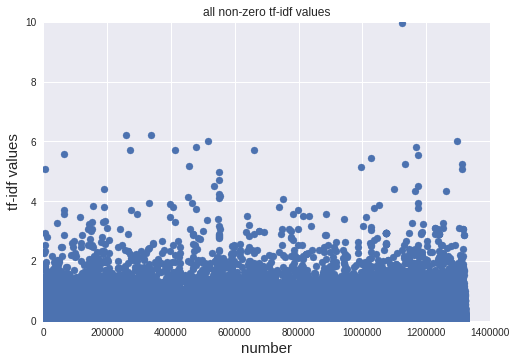

In [6]:
# inspect raw data
raw_data=csr_matrix(table)
non_zero_data=raw_data.data
non_zero_number=len(non_zero_data)

print('The number of non-zero tf-idf value is: ',non_zero_number)

x=np.arange(non_zero_number)
plt.title( 'all non-zero tf-idf values')  
plt.axis([0,1.4e6,0,10])
plt.ylabel('tf-idf values',fontsize=15)
plt.xlabel('number',fontsize=15)
plt.scatter(x,non_zero_data)
plt.show()

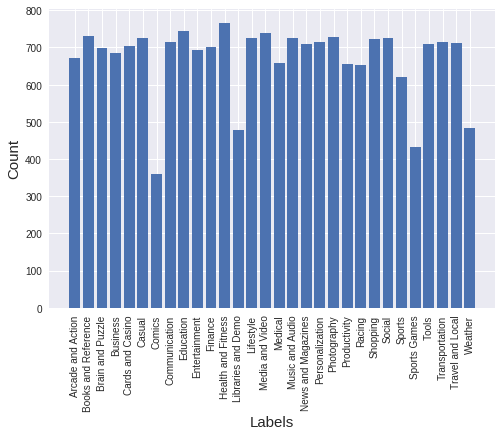

Arcade and Action 671
Books and Reference 730
Brain and Puzzle 699
Business 684
Cards and Casino 703
Casual 726
Comics 359
Communication 716
Education 743
Entertainment 692
Finance 702
Health and Fitness 766
Libraries and Demo 479
Lifestyle 726
Media and Video 738
Medical 657
Music and Audio 725
News and Magazines 710
Personalization 715
Photography 729
Productivity 656
Racing 654
Shopping 723
Social 726
Sports 621
Sports Games 432
Tools 709
Transportation 716
Travel and Local 713
Weather 484


In [7]:
# inspect labels
all_labels=sorted((set(labels[1])))
count=list()

for word in all_labels:
    index=np.array(labels.index[labels[1].str.strip()==word])
    count.append(len(index))
count=np.array(count)   


plt.bar(all_labels, height= count)
plt.xlabel('Labels',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(rotation=90)
plt.show()
for i in range(30):
    print(all_labels[i],count[i])

In [0]:
# reconstruct the raw data
def Reconstruct_table(table):
    table=csr_matrix(table)
    
    #PCA_Dimention_Reduction
    u,s,vt=svds(table, k=300)
    mean_value=table.mean()
    table_mean=table.toarray()-mean_value
    d_table=np.dot(table_mean,np.transpose(vt))
    return csr_matrix(d_table)

In [0]:
# reconstruct the labels, make them into a understandable form
def Reconstruct_labels(labels):
    rows=labels.shape[0]
    # find all the 30 labels
    all_labels=sorted((set(labels[1])))
    pre_labels = np.zeros(shape=(rows,30))
    i=0
    for word in all_labels:
        index=np.array(labels.index[labels[1].str.strip()==word])
        pre_labels[index,i]=1
        i=i+1
    pre_labels=csr_matrix(pre_labels)
    
    return pre_labels , all_labels

###Load and Inspect Data
The first step we performed was to load all the data into Colab. Due to 
the functionalities of Colab, the total memory we could use for this 
project was only 12 GB. However, after we loaded our data into the system, 
there were only around 2GB of free memory left. In order to save memory, 
we changed the float of the data from 64 to 32. 



After taking a close look in to the training\_data.csv, we found that it 
was a matrix with dimension of 20,104$\times $13,627, and it contained 
tf-idf value to represent how important a word is to the description. 
When we were inspecting the dataset, within the dataset we found that it 
only contained over 1.3 million of non-zero tf-idf value. We created a 
scatter plot on the distribution of the tf-idf value, and it showed that 
most of the tf-idf value was between 0 to 0,6 and with few outliers over 
0.6.



After looking into training\_data, we also performed descriptive 
statistics on training\_labels. And we found that on average each label 
has around 650 to 700 apps. Among all the labels, the label with the 
smallest number of apps is Comics (359), and Health and Fitness has the 
largest number of apps (766).

As stated in the assignment description, the same rows of training 
\_data and training\_labels might not be the same. We performed index 
sorting to make sure that each row in the training\_data correspond to 
the same app name in training\_labels. In order to prepare 
training\_labels for future analysis and processes, we decided to 
reconstruct the dataset into a matrix with app names vs. label 
categories. For example for app "com.borderstylo.retrollect", it would 
have 30 columns of data with different label names. Since its app label 
is Photography, then it will have a "1" under column of photography, 
and rest of columns would be "0" s. In this case, we created a matrix 
for training\_labels.

###Sparse Matrix

With concerns of exceeding memory storage, we decided to store the 
matrix in form of sparse matrix to cut down the memory usage. We used csr.matrix 
function from library *scipy.sparse* to sparse the matrix. 

###Principal Component Analysis (PCA)
After we loaded the data with changing the float and sparse 
matrix, the data is still too big, and we came up with another method to 
reduce data - dimension reduction. In this case, the method we used to 
preprocess the data was Principle Component Analysis(PCA). PCA is a 
statistical procedure to get the largest possible variance between 
variables. At same time, PCA could be used to find any strong patterns between variables, 
which means it would help with discovering relationship in the dataset（Powell and Lehe, 2018). 
There are many advantages for using PCA method, such as avoid 
overfitting. As we looked at the original data of training\_data, it 
contains too much information so that it would be difficult to extract 
information efficiently from it directly. 

Since the data we had was a parse matrix, we used singular 
value decomposition (SVD) method. SVD usually used for "compressing, 
denoising, and data reduction" (Brownlee, 2018), and in our case, we felt it would be a 
good method to deal with the training\_data. The basic algorithm 
representation of SVD is as follow: X$=U\Sigma V^{T}$. In order to 
process this step, we imported function of "svds" from library 
*scipy.sparse.linalg*, and we chose number of 300 important 
elements as in tf-idf value : "u,s,vt=svds(table, k=300)". 

### Classifier

In [0]:
# Classifier: logistic regression
class Multi_class_LR():
    def __init__(self,training_data,training_labels,test_data,all_labels,columns ):
        self.training_data=training_data
        self.training_labels=training_labels
        self.test_data=test_data
        self.all_labels=all_labels
        self.columns=columns
    
    def fit(self):
        self.weights_table=np.zeros(shape=(self.columns,30))
        # loop for 30 classes 
        for i in range(0,30):
            eta=0.5
            n_iter=20
            self.weights_table[:,i]=self.weight_calculate(self.training_data,self.training_labels[:,i],n_iter,eta)
        
        self.predict_table=self.logistic_predictions(csr_matrix(self.weights_table),self.test_data)
        self.predict_labels=self.my_predict()
        return self.predict_labels
    
    def weight_calculate(self,X,Y,n_iter,eta):
        N, D = X.shape
        weights = 5*np.random.random(D)[:, np.newaxis]
        for epoch in range(n_iter):
            dloss= self.logistic_loss_and_grad(csr_matrix(weights), X, Y)
            weights = weights  - dloss * eta 
        return np.transpose(weights)
    
    def logistic_loss_and_grad(self,weights, inputs, targets):
        #derivative of the loss function
        targets=targets.toarray()
        z = inputs.dot(weights).toarray()
        exp_z = np.exp(z)
        temp = -exp_z/(1 + exp_z) + targets
        m_t=csr_matrix(temp).multiply(inputs)
        sum_data=m_t.sum(axis=0)
        dloss = (-1)*np.array(sum_data)
        return np.transpose(dloss)
    
    def logistic_predictions(self,weights, inputs):
        z = inputs.dot(weights)
        z=z.toarray()
        # calculate the probability 
        return 1.0/(1.0 + np.exp(-z))
    _
    def my_predict(self):
        # find the maximum probability 
        max_predict=list()
        l=self.predict_table.shape[0]
        for i in range(0,l):
            index_n=np.argmax(self.predict_table[i,:])
            
            # return the class name for the maximum probability
            max_predict.append(self.all_labels[index_n])
        return np.array(max_predict)
         

In [0]:
# Classifier: Naive bayes
class Multi_class_Naive_Bayes():
    def __init__(self,training_data,training_labels,test_data,all_labels,columns ):
        self.training_data=training_data
        self.training_labels=training_labels
        self.test_data=test_data
        self.all_labels=all_labels
        self.columns=columns
    def fit(self):
        self.weights_table=np.zeros(shape=(self.columns,30))
        for i in range(0,30):
            one_class=self.training_labels[:,i]
            self.weights_table[:,i]=self.weight_calculate(one_class)
        
        self.predict_table=self.Bayes_predictions(self.test_data, csr_matrix(self.weights_table))
        self.predict_labels=self.my_predict()
        return self
    
    def weight_calculate(self,one_class):
        p_class=len(one_class.indices)/one_class.shape[0]
        filter_table=self.training_data.multiply(one_class)
        sum_all=filter_table.sum()
        sum_column=filter_table.sum(axis=0)
        
        # laplace smoothing and use logarithms due to very small floating point number probabilities
        a=0.1
        sum_column+=a*1
        sum_all+=a*self.columns
        weights=np.log(sum_column)-np.log(sum_all)+np.log(p_class)
        return weights
    def Bayes_predictions(self,inputs,weights):
        z = inputs.dot(weights)
        z=z.toarray()
        return z 
    
    def my_predict(self):
        max_predict=list()
        l=self.predict_table.shape[0]
        for i in range(0,l):
            index_n=np.argmax(self.predict_table[i,:])
            max_predict.append(self.all_labels[index_n])
        return np.array(max_predict)

###Logistic Regression classifier
Logistic regression is a widely-used predictive analysis with 
discriminative nature, which means has one binary dependent variable 
along with various types and number of independent variable (Brownlee, 2018). We also 
chose to use Gradient Descent Algorithm to fulfill the task of building 
the logistic regression for our project. By applying Gradient Descent 
Algorithm, we could get the parameter w that could minimise the overall 
loss:

\begin{equation}
    \underset{\mathbf{w}}{\operatorname{argmin}} \text{loss}(\mathbf{w}) 
    = \underset{\mathbf{w}}{\operatorname{argmin}} \sum_{i=1}^{N} \big( \log(1+e^z) - y_i z_i \big) 
\end{equation}



However, in order to find the minimised value of the overall loss we 
will need to solve the derivative of the function equal to zero, which is too complicate 
to achieve. We would use looping approach such as taking little steps 
using iterating process. In our code, we set eta of 0.5 and iteration of 
20 times, which means moving parameter in a direction of its steepest 
descent with a learning rate of 0.5. Since we needed to classify 30 
distinct labels in this project, we carried out a multi-class logistic 
regression. 



We generated a logistic regression process by putting each "label" as 
our dependent variable. In order to achieve the goal, we decided to 
create a loop for 30 classes and it would return as a table with weights 
of each classes. 

###Naive Bayes classifier
As a classic and popular algorithm for text classification and natural 
language processing, the Multinomial Naive Bayes classifier is a simple 
Bayesian classifier (Chatbots Life, 2017). The Bayesian classifier is based on the 
Bayes theorem:

\begin{equation}
P(C|A)=\frac{P(A|C)P(C)}{P(A)}
\end{equation}

Where C is the class and A is the attribute.



If there are multiple attributes with some possible classes, the above 
theorem can be represented as:
\begin{equation}
P(C_{k}|A_{1},A_{2},\ldots ,A_{n})=\frac{P(A_{1},A_{2},\ldots 
,A_{n}|C)P(C_{k})}{P(A_{1},A_{2},\ldots ,A_{n})}\\
\end{equation}



The posterior probability is a proportion to the multiplication of the 
prior probability and the likelihood. Therefore, the classification 
principle is to maximise the $P(C_{k}|A_{1},A_{2},\ldots ,A_{n})$ , 
which can be considered as maximise the $P(A_{1},A_{2},\ldots 
,A_{n}|C_{k})P(C_{k})$. The class with maximum probability will be the 
predicted result. The reason for this classifier named as naive is it 
assumes all the attributes are independent. The advantages of the naive 
Bayes classifier can be summarized as simple and fast, while the main 
disadvantage is that the interactions between features are not learned 
(Chen, 2011).

In our code, the raw tf-idf data is used instead of implementing PCA to 
reconstruct it. The first step is to select the data belong to the 
class, which we were working on. Due to pre-processing of the labels, it 
is easy to find the class probability and filter out the data by 
multiplying the labels and data matrix. Then, the $P(A_{1},A_{2},\ldots ,A_{n}|C_{k})$ can be calculated as 
the sum of each column of the filtered matrix divided by the sum of the 
whole filtered matrix. Moreover, the class probability is the sum of the 
labels matrix divided by the length of the matrix.
\begin{equation}
  Data\space matrix * Labels\space matrix = Filtered \space matrix
\end{equation}

\begin{equation}
P(A_{1},A_{2},\ldots ,A_{n}|C_{k})=\frac{sum\space of\space each\space column }{sum\space of\space 
the\space whole\space matrix }\\
\end{equation}

\begin{equation}
P (C_{K})=\frac{sum\space of\space the\space labels\space matrix}{length\space of\space the\space labels\space matrix}
\end{equation}




The Laplace smoothing is applied to prevent the zero-probability 
problem. When the sum of a column is zero, it would generate zero 
probability when doing the multiplication. The Laplace smoothing theory 
is to add a $\alpha 1 $to the numerator and a $\alpha k$ to 
denominator, in order to ensure the sum of all probabilities always 
equal to 1. The $k$ is the number of $x_{i}$ and the $\alpha $ is 
typically equal to 1 or sometimes a small value. 

\begin{equation}
P=\frac{P(x_{i})}{N} \gg P_{LS}=\frac{P(x_{i})+\alpha }{N+\alpha k}
\end{equation}



In our code, the $\alpha $ was 0.1. In addition, it would be more 
precise to use logarithm for calculation the small probability value. 
\begin{equation}
\log (\frac{P(A)}{P(B)})=\log (P(A))-log(P(B))
\end{equation}



Finally, after computing all the patterns for each class, the prediction 
could be made by finding the maximum probability, which is similar to 
the logistics regression classifier. 


## C. Experiments and Results (max 500 words)

In [0]:
def score_performance(p,c):
    count=0
    l=c.shape[0]
    for i in range(0,l):
        if p[i]==c[i]:
            count=count+1
    return float (count)/float(l)

In [0]:
def generate_confusion_matrix(predict_labels,correct_labels,all_labels):
    size=predict_labels.shape[0]
    l=len(all_labels)
    confusion_matrix=np.zeros(shape=(l,l))
    for i in range(size):
        predict_index=all_labels.index(predict_labels[i])
        correct_index=all_labels.index(correct_labels[i])
        confusion_matrix[correct_index,predict_index]+=1
    return confusion_matrix

In [0]:
def plot_confusion_matrix(confusion_matrix,all_labels):
    df_cm = pd.DataFrame(confusion_matrix, index = all_labels,columns = all_labels)
    plt.figure(figsize = (15,9))
    sn.heatmap(df_cm, annot=True)

In [0]:
def analyze_confuson_matrix(confusion_matrix,all_labels):
    array1=np.zeros(shape=(1,4))
    for word in all_labels:
        index=all_labels.index(word)
        TP=float (confusion_matrix[index,index])
        FN =float( np.sum(confusion_matrix[index]) - TP)
        FP =float (np.sum(confusion_matrix[:, index]) - TP)
        TN = float (np.sum(confusion_matrix) - TP - FN - FP)
        precision=TP / (TP + FP)
        recall=TP / (TP + FN)
        F_measure=2*TP / (2*TP + FP + FN)
        #accuracy=(TP + TN) / (TP + TN + FP + FN)
        support=(TP + FN)
        array2=np.zeros(shape=(1,4))
        array2[0,0]=precision
        array2[0,1]=recall
        array2[0,2]=F_measure
        array2[0,3]=support
        array1=np.vstack((array1,array2))
    ana_data=array1[1:31,:]
    df_data = pd.DataFrame(ana_data, columns = ['Precision', 'Recall', 'F-measure','Support'], index = all_labels)
    print(df_data)
    return df_data

In [0]:
def K_fold_validation_NB(table, labels):
    start_time = datetime.datetime.now()
    K=10
    pre_labels , all_labels=Reconstruct_labels(labels)
    table=csr_matrix(table)
    rows,columns=table.shape
    test_length=float(rows/K)
    cm=np.zeros(shape=(30,30))
    all_precision=np.zeros(shape=(K,1))
    for i in range(K):
        start=int(i*test_length)
        finish=int((i+1)*test_length)
        test_data=table[start:finish,:]
        training_data=vstack([table[0:start,:],table[finish:rows,:]])
        correct_labels=np.array(labels[start:finish])
        training_labels=vstack([pre_labels[0:start,:],pre_labels[finish:rows,:]])
        NB=Multi_class_Naive_Bayes(training_data,training_labels,test_data,all_labels,columns)
        NB.fit()
        temp_cm=generate_confusion_matrix(NB.predict_labels,correct_labels,all_labels)
        cm+=temp_cm
        all_precision[i,0]=score_performance(NB.predict_labels,correct_labels)
        print(i+1,all_precision[i,0])
    analyze_confuson_matrix(cm,all_labels)
    
    average_precision=sum(all_precision)/K
    print('The average corrected prediction is: ',average_precision)
    plot_confusion_matrix(cm,all_labels)
    print('Running time is ',datetime.datetime.now() - start_time)

In [0]:
# Perform K fold validation, default is 10
def K_fold_validation_LR(table, labels):
    start_time = datetime.datetime.now()
    K=10
    reconstruct_table=Reconstruct_table(table)
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=reconstruct_table.shape
    test_length=float(rows/K)
    cm=np.zeros(shape=(30,30))
    all_precision=np.zeros(shape=(K,1))
    
    for i in range(K):
        start=int(i*test_length)
        finish=int((i+1)*test_length)
        test_data=reconstruct_table[start:finish,:]
        training_data=vstack([reconstruct_table[0:start,:],reconstruct_table[finish:rows,:]])
        correct_labels=np.array(labels[start:finish])
        training_labels=vstack([pre_labels[0:start,:],pre_labels[finish:rows,:]])
        LR=Multi_class_LR(training_data,training_labels,test_data,all_labels,columns)
        LR.fit()
        temp_cm=generate_confusion_matrix(LR.predict_labels,correct_labels,all_labels)
        cm+=temp_cm
        all_precision[i,0]=score_performance(LR.predict_labels,correct_labels)
        print(i+1,all_precision[i,0])
    analyze_confuson_matrix(cm,all_labels)
    average_precision=sum(all_precision)/K
    print('The average corrected prediction is: ',average_precision)
    plot_confusion_matrix(cm,all_labels)
    print('Running time is ',datetime.datetime.now() - start_time)   
        

1 0.6114427860696517
2 0.5940298507462687
3 0.5912481352560915
4 0.6139303482587065
5 0.583291894579811
6 0.6238805970149254
7 0.6059701492537314
8 0.6056688214818499
9 0.5626865671641791
10 0.5897563401292889
                     Precision    Recall  F-measure  Support
Arcade and Action     0.493491  0.621461   0.550132    671.0
Books and Reference   0.560178  0.516438   0.537420    730.0
Brain and Puzzle      0.617876  0.682403   0.648538    699.0
Business              0.578467  0.463450   0.514610    684.0
Cards and Casino      0.848980  0.887624   0.867872    703.0
Casual                0.433052  0.494490   0.461736    726.0
Comics                0.918919  0.094708   0.171717    359.0
Communication         0.500629  0.555866   0.526803    716.0
Education             0.546154  0.668910   0.601331    743.0
Entertainment         0.376906  0.250000   0.300608    692.0
Finance               0.786632  0.871795   0.827027    702.0
Health and Fitness    0.644397  0.780679   0.706021    766

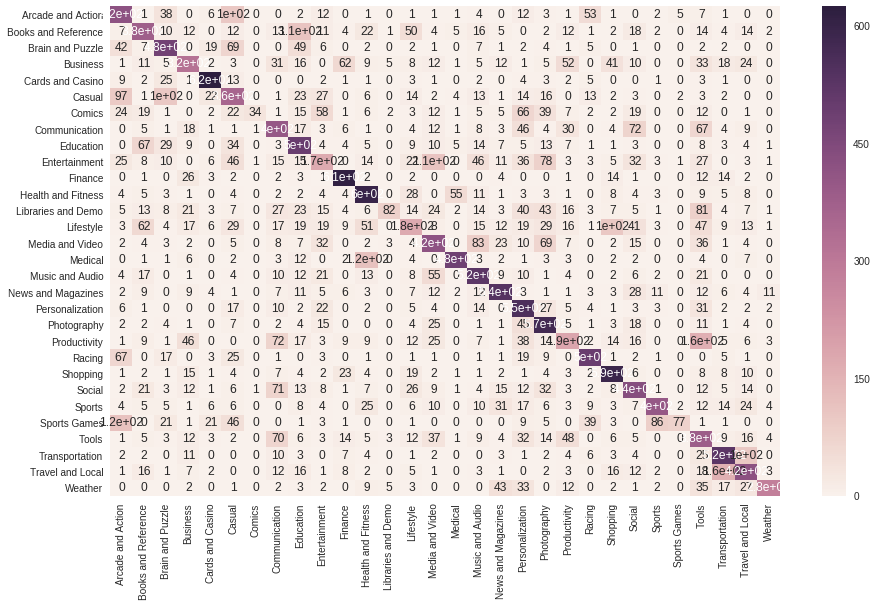

In [20]:
K_fold_validation_NB(table, labels)

In [23]:
K_fold_validation_LR(table, labels)

5 0.5494778717056191
6 0.5865671641791045
7 0.5582089552238806
8 0.5629040278468423
9 0.527363184079602
10 0.5599204375932372


ValueError: ignored

### Accuracy

####	Logistic Regression Examine
For the testing part of logistic regression, we used 10-fold cross validation for our training dataset. The line of code was “K_fold_validation_LR(table, labels)”. The runtime for this process was around 10 minutes and 19 seconds. For the outcome of our 10-fold cross validation, we got the calculated the overall accuracy for each trial. Among the ten accuracy outcomes, the lowest accuracy is at 52.24%, and the highest accuracy is at 57.43%. On average, the accuracy of using Logistic regression method is 55.19%. The accuracy we got was calculated using formula as follow:
\begin{equation}
Accuracy = Diagonal\space / \space All \space observation 
\end{equation}

####Naïve Bayes Examine
We also carried out 10-fold cross validation to test the performance of Naïve Bayes. The line of code was “K_fold_validation_NB(table, labels)”. The estimated runtime for this process is 10 seconds. The reason for getting outcome in such a short time is that instead of using np array, we did preprocessing steps such as using sparse matrix and reconstructing training_labels dataset. Among the ten accuracy outcomes, the lowest accuracy is at 56.27%, and the highest accuracy is at 62.39%. On average, the accuracy of using Naïve Bayes method is 59.82%. 


### Extensive Analysis



####Logistic Regression – Detailed Analysis
We then decided to look into the performance of different classes (labels), we included the following performance estimation: Precision, Recall, F-measure, and support. Among those parameters we’d like to pay more attention to precision of each classes. Precision was generated from:
\begin{equation}
Precision = TP / (TP +FP)
\end{equation}
It was also called the positive predictive value and we would think of it as a ratio for number of correct prediction vs. number of total prediction of a specific class. We measured the precision parameters in the process of 10-fold cross validation. From the table we generated, we could see that class Lifestyle has the lowest precision of 0.16 and the class Cards and Casino has the highest precision of 0.85. To present our outcome in a more understandable form, we generated a large confusion matrix to represent the 10-fold cross validation outcomes for 30 classes. 

####Naïve Bayes – Detailed Analysis
As for Naïve Bayes method, when we looked at the performance of different classes, we found similar outcome. However, the runtime for Naïve Bayes was decreased significantly. The precision for each class are slightly higher than those in Logistic Regression. 



## D. Export Results 

**Insert the url address of your predicted_labels.csv file:   **

https://drive.google.com/open?id=1GqJ5K17r2ZnjsxUxmjXudkHtrGkzekNp

In [0]:
# Get the predict labels for the test data
def test_labels_generate(table, test,labels):
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=table.shape
    table=csr_matrix(table)
    test=csr_matrix(test)
    NB=Multi_class_Naive_Bayes(table,pre_labels,test,all_labels,columns)
    NB.fit()
    return NB.predict_labels

In [0]:
# export output
test_predict_data=test_labels_generate(table,df_test,labels)
df_predict=pd.DataFrame(test_predict_data,index=df_test.index)
df_predict.to_csv('predict_labels.csv',header=False)

## E. Discussion (max 300 words)

With the above study performed, it was clear that pre-processing is a crucial step for performing any analyses. After generating classifiers using both Logistics Regression and Naïve Bayes, we realise that Naïve Bayes would be a more fitful method for this study. There are many reasons and evidences that could back the idea. First of all, Naïve Bayes required less runtime in this study. Secondly, the accuracy for Naïve Bayes is 59.82% which is higher than the accuracy for Logistic Regression of 55.19%. Thirdly, when looking at the codes, Naïve Bayes had less steps required for its performance. Fourthly, Naïve Bayes assumes all the variables in the model are independent, and the nature of tf-idf value is that each variable is independent. In this case, Naïve Bayes would be a good fit for the dataset type. Last but not least, in our Logistic Regression, we used PCA to process the data reduction process. Due to data reduction, it is unavoidable that the accuracy for the outcome of Logistic Regression would be decreased.

We also thought about the reason why class Lifestyle would have such low precision in our prediction. It might because that the lifestyle app usually includes frequently used words in its description, and in that case, it would have impact on the tf-idf value of these apps. On the other hand, the reason why class Card and Casino had relatively high precision can also be explained. The description of Card and Casino app might use jargons that would influence the tf-idf value.  


## F. Conclusion and future work (max 200 words)

In conclusion, our study seems to successfully in achieving goal of creating classifiers to classify apps based on their description (tf-idf file). We believe that after conducting above analyses and examination, we are confident that comparing to use Logistic Regression approach, using Naïve Bayes method in this dataset would return in more accurate result. After compare and contrast the two methods, we had a better understanding on how to perform machine learning in various approaches and to examine the outcomes. As for future work suggested, overfitting should be an important topic for this study (Statistics Solutions, 2018).

## G. References

list of references

1. Chatbots Life. (2017). Text Classification using Algorithms – Chatbots Life. [online] Available at: https://chatbotslife.com/text-classification-using-algorithms-e4d50dcba45 [Accessed 6 May 2018].  
2. Chen, E. (2011). Choosing a Machine Learning Classifier. [online] Blog.echen.me. Available at: http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/ [Accessed 6 May 2018].
3. 
Powell, V. and Lehe, L. (2018). Principal Component Analysis explained visually. [online] Explained Visually. Available at: http://setosa.io/ev/principal-component-analysis/ [Accessed 6 May 2018].
4. Brownlee, J. (2018). A Gentle Introduction to Singular-Value Decomposition for Machine Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/ [Accessed 6 May 2018].
5. Statistics Solutions. (2018). What is Logistic Regression? - Statistics Solutions. [online] Available at: https://www.statisticssolutions.com/what-is-logistic-regression/ [Accessed 6 May 2018].
6. Brownlee, J. (2018). Logistic Regression for Machine Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/logistic-regression-for-machine-learning/ [Accessed 6 May 2018].


# Sumbitting your assignment

You must share only 1 folder with your tutor.
The folder should have your group's unikeys in its name ( example: Assignment1_abxy6273_edfr3373_yhfr4534 ).

The folder should contain a Colab notebook and the output file.

Suggested structure of the folder:

* Data
 * training_data.csv
 * training_desc.csv
 * training_labels.csv
 * test_data.csv
* Assignment1.ipynb
* predicted_labels.csv

Ask your tutor for his email address and share the properly named folder with him before 5:00pm on May 7th 2018. 
Every late day will cost you 20 marks.

